In [2]:
#To connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# --- Import required libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define column names based on wdbc.names
columns = ['id', 'diagnosis',
           'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
           'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean',
           'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se',
           'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se',
           'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst',
           'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst',
           'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']

# Load the dataset with column names from the Google Drive
df = pd.read_csv('/content/drive/MyDrive/breast+cancer+wisconsin+original/wdbc.data', header=None, names=columns)

# Preview the data
print(df.info())
print(df.describe())

# ---Data Preprocessing ---
# Drop ID and map target labels
X = df.drop(['id', 'diagnosis'], axis=1)
y = df['diagnosis'].map({'M': 1, 'B': 0})  # Malignant = 1, Benign = 0

# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [9]:
#Top 5 records
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


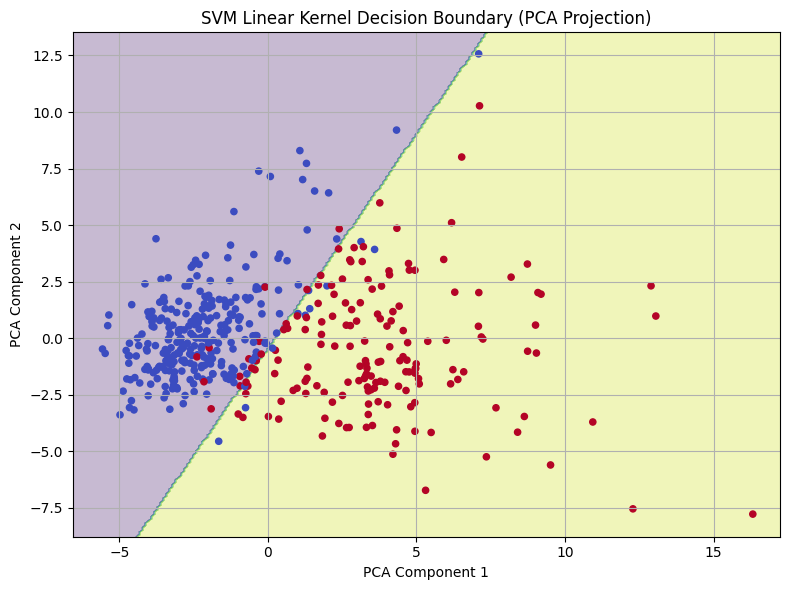

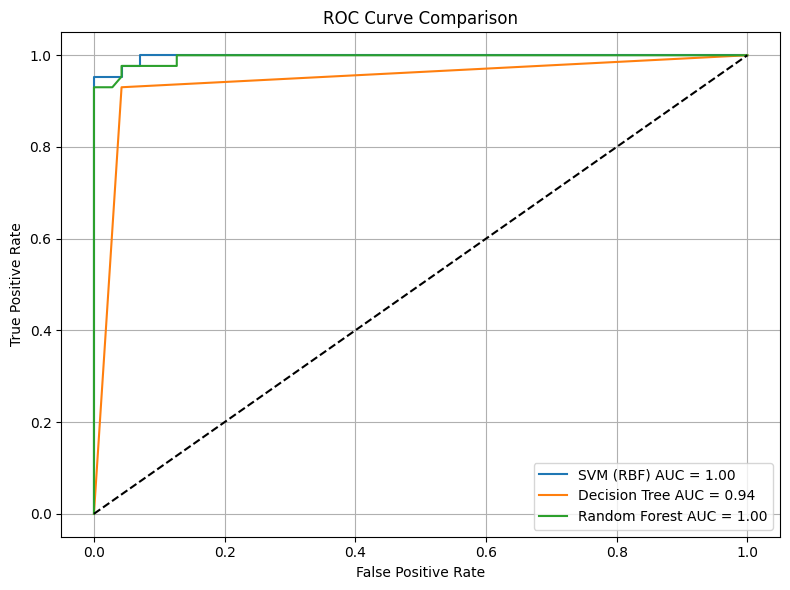

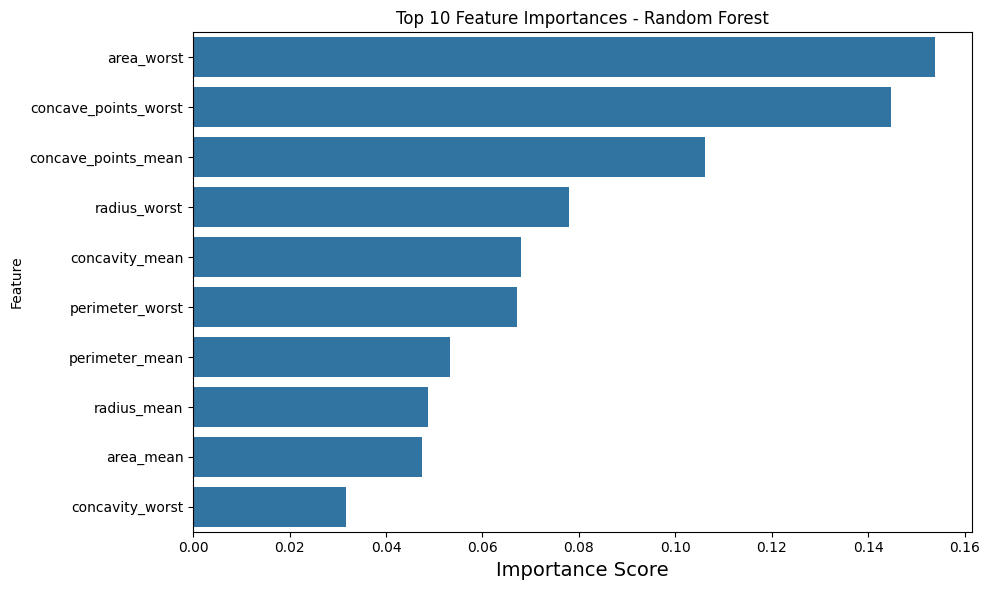


Model Performance Summary:
            Model  Accuracy  AUC Score
0      SVM (RBF)    0.9825     0.9974
1  Decision Tree    0.9474     0.9440
2  Random Forest    0.9649     0.9953


In [6]:
# --- Split into train/test sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Feature scaling for SVM ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- PCA Projection for SVM Decision Boundary (Linear Kernel) ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.fit_transform(X))  # full dataset scaled before PCA
X_train_pca, _, y_train_pca, _ = train_test_split(X_pca, y, test_size=0.2, random_state=42)

svm_linear_pca = SVC(kernel='linear')
svm_linear_pca.fit(X_train_pca, y_train_pca)

x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = svm_linear_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_pca, cmap='coolwarm', s=20)
plt.title('SVM Linear Kernel Decision Boundary (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Model Training & Prediction ---

# SVM with RBF Kernel
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train_scaled, y_train)
y_pred_svm = svm_rbf.predict(X_test_scaled)
y_prob_svm = svm_rbf.decision_function(X_test_scaled)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# --- ROC Curve and AUC Comparison ---
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

auc_svm = roc_auc_score(y_test, y_prob_svm)
auc_dt = roc_auc_score(y_test, y_prob_dt)
auc_rf = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (RBF) AUC = {auc_svm:.2f}')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree AUC = {auc_dt:.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest AUC = {auc_rf:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Feature Importance from Random Forest ---
feature_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp.values[:10], y=feature_imp.index[:10])
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- Summary Table of Results ---
summary_df = pd.DataFrame({
    "Model": ["SVM (RBF)", "Decision Tree", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf)
    ],
    "AUC Score": [auc_svm, auc_dt, auc_rf]
})

print("\nModel Performance Summary:\n", summary_df.round(4))


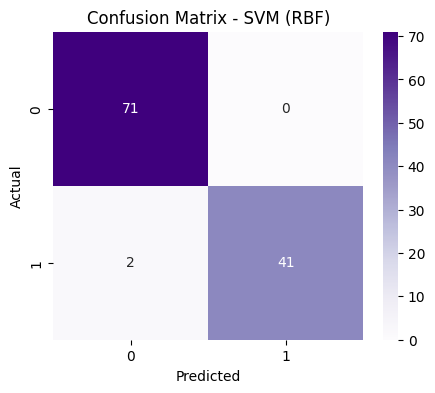

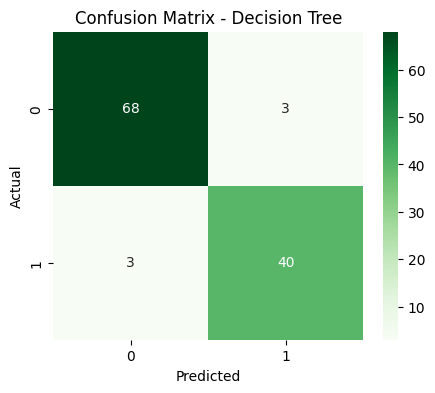

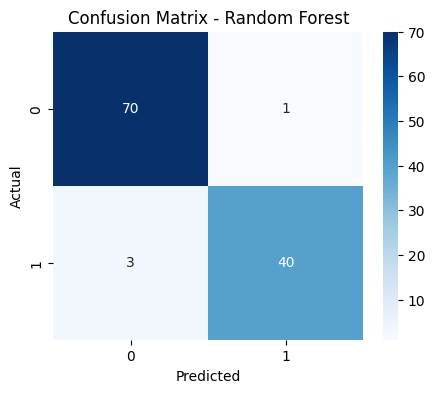

In [7]:
# --- Plot Confusion Matrix ---
# --- Visualize Confusion Matrices as Heatmaps ---
# SVM Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - SVM (RBF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Decision Tree Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Random Forest Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
summary_df['Precision'] = [
    classification_report(y_test, y_pred_svm, output_dict=True)['weighted avg']['precision'],
    classification_report(y_test, y_pred_dt, output_dict=True)['weighted avg']['precision'],
    classification_report(y_test, y_pred_rf, output_dict=True)['weighted avg']['precision']
]

summary_df['Recall'] = [
    classification_report(y_test, y_pred_svm, output_dict=True)['weighted avg']['recall'],
    classification_report(y_test, y_pred_dt, output_dict=True)['weighted avg']['recall'],
    classification_report(y_test, y_pred_rf, output_dict=True)['weighted avg']['recall']
]

summary_df['F1 Score'] = [
    classification_report(y_test, y_pred_svm, output_dict=True)['weighted avg']['f1-score'],
    classification_report(y_test, y_pred_dt, output_dict=True)['weighted avg']['f1-score'],
    classification_report(y_test, y_pred_rf, output_dict=True)['weighted avg']['f1-score']
]

print("\n Extended Model Comparison:\n", summary_df.round(4))


 Extended Model Comparison:
            Model  Accuracy  AUC Score  Precision  Recall  F1 Score
0      SVM (RBF)    0.9825     0.9974     0.9829  0.9825    0.9824
1  Decision Tree    0.9474     0.9440     0.9474  0.9474    0.9474
2  Random Forest    0.9649     0.9953     0.9652  0.9649    0.9647


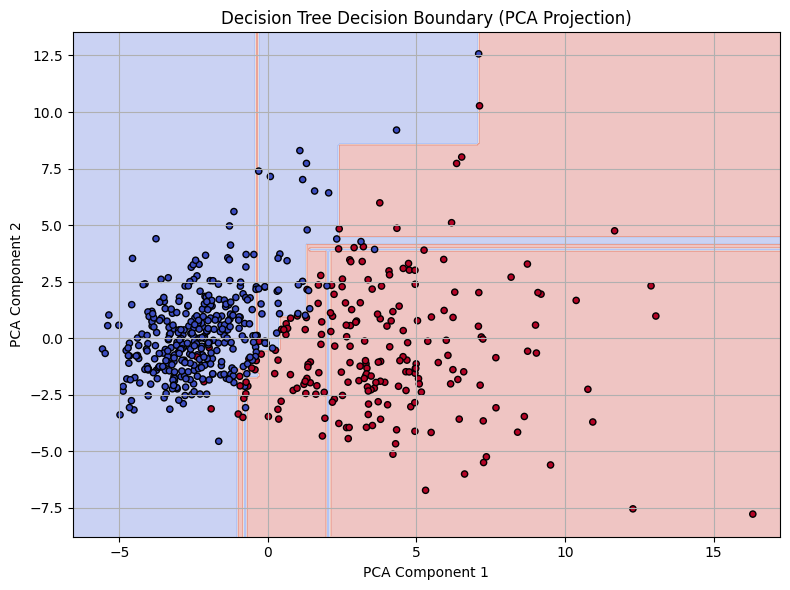

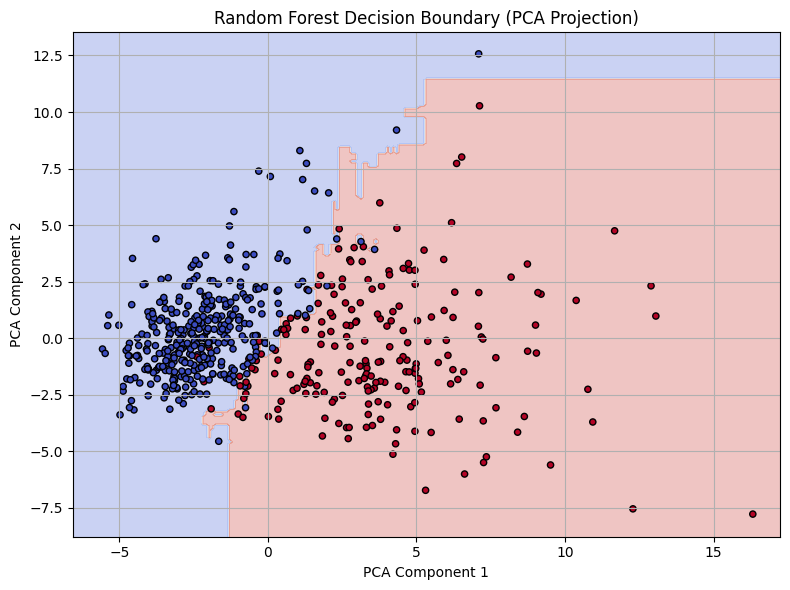

In [21]:
# Scale and apply PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create meshgrid for plotting
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# --- Decision Tree ---
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_pca, y)
Z_dt = dt.predict(grid_points).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_dt, alpha=0.3, cmap='coolwarm')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', s=20, edgecolor='k')
plt.title('Decision Tree Decision Boundary (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_pca, y)
Z_rf = rf.predict(grid_points).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_rf, alpha=0.3, cmap='coolwarm')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', s=20, edgecolor='k')
plt.title('Random Forest Decision Boundary (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()
